---

# 1. Objetivo

El propósito de esta tarea es comparar el desempeño de arquitecturas de tipo encoder (modelos BERT ajustados con una cabeza de clasificación) y decoder (modelos de lenguaje autoregresivos mediante prompting sin ajuste de parámetros) en tareas de clasificación de texto.

Utilizarán los mismos conjuntos de datos empleados en tareas previas: 20Newsgroups para clasificación multiclase y Multi-Domain Sentiment Dataset para análisis de sentimiento.

Esta comparación permitirá analizar los límites, ventajas y desventajas de cada enfoque bajo restricciones computacionales razonables.

---

## 1.1. Instrucciones Generales

- ~~Utilice Jupyter Notebooks para el desarrollo de la tarea.~~
- Incluya docstrings detallados en todas las clases, funciones y métodos.
- Ejecu­te todos los bloques de código y asegúrese de incluir los resultados en la entrega.
- Presente un informe en PDF que resuma la metodología, resultados y análisis comparativo.
- ~~Pueden realizar en grupos de hasta 4 personas~~

# 2. Dividir datasets (Se usan los mismos que el notebook de finetuning de encoders)

Para ambos datasets, divida los datos en conjuntos de entrenamiento, validación y prueba siguiendo los mismos porcentajes que en las tareas anteriores.

### Datasets

- 20Newsgroups: Clasificación en 20 categorías temáticas.

- Multi-Domain Sentiment Dataset: Clasificación binaria de sentimiento (positivo/negativo) en cuatro categorías: Books, DVD, Electronics, Kitchen.

# 3. PROMPTS

- Para los modelos decoder, diseñe prompts efectivos y utilice las respuestas generadas para inferir la clase correspondiente.

* No es obligatorio ajustar los pesos de los modelos; puede utilizar técnicas de **prompting** para resolver las tareas de clasificación.

* Diseñe prompts específicos para cada tarea, justificando su redacción y estructura.

* Ejemplo de prompt para clasificación de sentimiento:

```
Review: "The battery life of this camera is amazing."
Sentiment (positive/negative):
```

* Ejemplo de prompt para clasificación de newsgroups:

```
Text: "The new Linux kernel has improved networking features."
Category:
```

## 3.1. Análisis Exploratorio de Datos (EDA) para usar las características en los prompts

El objetivo es entender la estructura, características y distribuciones de los datasets

In [3]:
!pip install pandas matplotlib seaborn

In [3]:
def run_eda(RUTA_TRAIN_CSV: str, dataset_name: str):
    """
    EDA — exactamente el código original pero sin duplicación de bloques.
    Se muestra en notebook en vez de guardar PNG.
    """

    # Importar librerías necesarias
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter
    import re
    import warnings
    warnings.filterwarnings('ignore')

    # Configuración de visualización
    plt.rcParams['figure.figsize'] = (12, 8)
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 10

    print("Librerías importadas exitosamente")

    # Cargar el dataset
    print("Cargando dataset...")
    df = pd.read_csv(RUTA_TRAIN_CSV)

    print(f"Dataset cargado: {len(df)} registros")
    print(f"Columnas: {list(df.columns)}")

    # Información básica del dataset
    print("\n=== INFORMACIÓN BÁSICA DEL DATASET ===")
    print(f"- Forma: {df.shape}")
    print(f"- Columnas: {list(df.columns)}")
    print(f"- Memoria usada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Información detallada
    print("\n=== INFORMACIÓN DETALLADA ===")
    print(df.info())

    # Verificar valores nulos
    print("\n=== VALORES NULOS ===")
    print(df.isnull().sum())
    print(f"\nTotal de valores nulos: {df.isnull().sum().sum()}")

    # Estadísticas descriptivas de columnas numéricas
    print("\n=== ESTADÍSTICAS DESCRIPTIVAS (COLUMNAS NUMÉRICAS) ===")
    print(df.describe())

    # Análisis de columnas categóricas
    print("\n=== ANÁLISIS DE COLUMNAS CATEGÓRICAS ===")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'text':  # Excluir la columna de texto principal
            print(f"\n{col}:")
            print(f"- Valores únicos: {df[col].nunique()}")
            print(f"- Valores más frecuentes:")
            print(df[col].value_counts().head(10))

    # === analizar longitudes ===
    def analyze_text_lengths(df, text_column, dataset_name):
        print(f"\n=== ANÁLISIS DE LONGITUDES - {dataset_name.upper()} ===")
        
        char_lengths = df[text_column].str.len()
        word_lengths = df[text_column].str.split().str.len()
        sentence_lengths = df[text_column].str.split(r'[.!?]+').str.len()

        # prints sin tocar (pego literal)
        print(f"\nLongitud en caracteres:")
        print(f"- Mínimo: {char_lengths.min():,}")
        print(f"- Máximo: {char_lengths.max():,}")
        print(f"- Promedio: {char_lengths.mean():,.0f}")
        print(f"- Mediana: {char_lengths.median():,.0f}")
        print(f"- Desviación estándar: {char_lengths.std():,.0f}")
        print(f"- Q1: {char_lengths.quantile(0.25):,.0f}")
        print(f"- Q3: {char_lengths.quantile(0.75):,.0f}")

        print(f"\nLongitud en palabras:")
        print(f"- Mínimo: {word_lengths.min():,}")
        print(f"- Máximo: {word_lengths.max():,}")
        print(f"- Promedio: {word_lengths.mean():,.0f}")
        print(f"- Mediana: {word_lengths.median():,.0f}")
        print(f"- Desviación estándar: {word_lengths.std():,.0f}")
        print(f"- Q1: {word_lengths.quantile(0.25):,.0f}")
        print(f"- Q3: {word_lengths.quantile(0.75):,.0f}")

        print(f"\nNúmero de oraciones (aproximado):")
        print(f"- Mínimo: {sentence_lengths.min():,}")
        print(f"- Máximo: {sentence_lengths.max():,}")
        print(f"- Promedio: {sentence_lengths.mean():,.0f}")
        print(f"- Mediana: {sentence_lengths.median():,.0f}")

        return char_lengths, word_lengths, sentence_lengths

    char_lens, word_lens, sent_lens = analyze_text_lengths(df, 'text', dataset_name)

    # Visualización (SIN savefig → show)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes[0,0].hist(word_lens, bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].hist(char_lens, bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].boxplot([word_lens], labels=['Palabras'])
    axes[1,1].boxplot([char_lens], labels=['Caracteres'])
    plt.tight_layout()
    plt.show()

        # Análisis de distribución de etiquetas
    if 'label_name' in df.columns:
        print("\n=== ANÁLISIS DE DISTRIBUCIÓN DE ETIQUETAS ===")
        label_counts = df['label_name'].value_counts()
        print(f"\nTotal de etiquetas únicas: {df['label_name'].nunique()}")
        print(f"\nDistribución de etiquetas:")
        print(label_counts)
        
        # Visualización de distribución de etiquetas
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Gráfico de barras horizontal
        top_labels = label_counts.head(20)  # Top 20 etiquetas
        axes[0].barh(range(len(top_labels)), top_labels.values)
        axes[0].set_yticks(range(len(top_labels)))
        axes[0].set_yticklabels(top_labels.index)
        axes[0].set_xlabel('Frecuencia')
        axes[0].set_title('Top 20 Etiquetas Más Frecuentes', fontsize=12, fontweight='bold')
        axes[0].invert_yaxis()
        
        # Gráfico de pastel (solo top 10)
        top_10_labels = label_counts.head(10)
        other_count = label_counts.tail(-10).sum()
        if other_count > 0:
            pie_data = list(top_10_labels.values) + [other_count]
            pie_labels = list(top_10_labels.index) + ['Otros']
        else:
            pie_data = top_10_labels.values
            pie_labels = top_10_labels.index
        
        axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Distribución de Etiquetas (Top 10)', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    # Análisis de balance de clases
    if 'label' in df.columns:
        print("\n=== ANÁLISIS DE BALANCE DE CLASES ===")
        label_dist = df['label'].value_counts().sort_index()
        print(f"\nDistribución de clases (label numérico):")
        print(label_dist)
        
        # Calcular balance
        class_balance = label_dist / len(df)
        print(f"\nBalance de clases:")
        for label, balance in class_balance.items():
            print(f"- Clase {label}: {balance:.2%}")
        
        # Verificar si está balanceado
        balance_ratio = class_balance.min() / class_balance.max()
        print(f"\nRatio de balance (min/max): {balance_ratio:.3f}")
        if balance_ratio > 0.8:
            print("✓ Dataset relativamente balanceado")
        elif balance_ratio > 0.5:
            print("⚠ Dataset moderadamente desbalanceado")
        else:
            print("✗ Dataset muy desbalanceado - considerar técnicas de balanceo")

    # Análisis de splits
    if 'split' in df.columns:
        print("\n=== ANÁLISIS DE SPLITS ===")
        split_counts = df['split'].value_counts()
        print(f"\nDistribución de splits:")
        print(split_counts)
        print(f"\nPorcentajes:")
        for split, count in split_counts.items():
            print(f"- {split}: {count/len(df):.2%}")

    # Análisis de patrones de texto
    def analyze_text_patterns(df, text_column, dataset_name):
        """Analiza patrones comunes en el texto"""
        print(f"\n=== ANÁLISIS DE PATRONES - {dataset_name.upper()} ===")
        
        # Muestra para análisis (si el dataset es muy grande)
        sample_size = min(10000, len(df))
        sample_df = df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df
        
        # Combinar una muestra del texto
        sample_text = ' '.join(sample_df[text_column].astype(str).head(1000))
        
        # Patrones comunes
        patterns = {
            'Emails': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
            'URLs': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
            'Números': r'\b\d+\b',
            'Palabras en mayúsculas': r'\b[A-Z]{3,}\b',
            'Puntuación múltiple': r'[!?]{2,}',
        }
        
        for pattern_name, pattern in patterns.items():
            matches = re.findall(pattern, sample_text)
            print(f"- {pattern_name}: {len(matches)} ocurrencias en muestra")
            if matches and len(matches) > 0 and len(matches) <= 10:
                examples = list(set(matches))[:5]
                print(f"  Ejemplos: {', '.join(examples)}")
        
        # Análisis de palabras más comunes
        words = re.findall(r'\b[a-zA-Z]{3,}\b', sample_text.lower())
        word_freq = Counter(words)
        print(f"\nPalabras más comunes (top 20):")
        for word, freq in word_freq.most_common(20):
            print(f"- {word}: {freq:,}")
        
        return word_freq

    # Analizar patrones de texto
    text_patterns = analyze_text_patterns(df, 'text', 'Textos')

    # Análisis de calidad de datos
    def analyze_data_quality():
        """Analiza la calidad de los datos y detecta posibles problemas"""
        print("\n=== ANÁLISIS DE CALIDAD DE DATOS ===")
        
        # 1. Verificar duplicados
        print("\n1. Duplicados:")
        text_dups = df.duplicated('text').sum()
        total_dups = df.duplicated().sum()
        print(f"- Textos duplicados: {text_dups}")
        print(f"- Filas completamente duplicadas: {total_dups}")
        if text_dups > 0:
            print(f"  Porcentaje de duplicados: {text_dups/len(df):.2%}")
        
        # 2. Textos muy cortos o muy largos (outliers)
        print("\n2. Outliers de longitud:")
        
        # Percentiles para identificar outliers
        word_q1 = word_lens.quantile(0.25)
        word_q3 = word_lens.quantile(0.75)
        word_iqr = word_q3 - word_q1
        word_outliers = ((word_lens < (word_q1 - 1.5 * word_iqr)) | 
                         (word_lens > (word_q3 + 1.5 * word_iqr))).sum()
        
        char_q1 = char_lens.quantile(0.25)
        char_q3 = char_lens.quantile(0.75)
        char_iqr = char_q3 - char_q1
        char_outliers = ((char_lens < (char_q1 - 1.5 * char_iqr)) | 
                         (char_lens > (char_q3 + 1.5 * char_iqr))).sum()
        
        print(f"- Outliers en palabras: {word_outliers} ({word_outliers/len(df):.2%})")
        print(f"- Outliers en caracteres: {char_outliers} ({char_outliers/len(df):.2%})")
        
        # 3. Textos extremadamente cortos
        print("\n3. Textos extremadamente cortos:")
        very_short_words = (word_lens < 10).sum()
        very_short_chars = (char_lens < 50).sum()
        
        print(f"- Textos con menos de 10 palabras: {very_short_words}")
        print(f"- Textos con menos de 50 caracteres: {very_short_chars}")
        
        # 4. Textos vacíos o casi vacíos
        print("\n4. Textos vacíos o problemáticos:")
        empty_texts = (df['text'].isna() | (df['text'].str.strip() == '')).sum()
        print(f"- Textos vacíos o nulos: {empty_texts}")
        
        return {
            'duplicates': text_dups,
            'word_outliers': word_outliers,
            'char_outliers': char_outliers,
            'very_short': very_short_words,
            'empty': empty_texts
        }

    quality_metrics = analyze_data_quality()

    # Ejemplos representativos
    def show_examples():
        """Muestra ejemplos de diferentes longitudes"""
        print("\n=== EJEMPLOS REPRESENTATIVOS ===")
        
        # Encontrar ejemplos de diferentes longitudes
        short_idx = word_lens.idxmin()  # Más corto
        long_idx = word_lens.idxmax()   # Más largo
        median_idx = (word_lens - word_lens.median()).abs().idxmin()  # Mediano
        
        examples = [
            (short_idx, "MÁS CORTO"),
            (median_idx, "MEDIANO"),
            (long_idx, "MÁS LARGO")
        ]
        
        for idx, label in examples:
            text = df.iloc[idx]['text']
            words = len(text.split())
            chars = len(text)
            label_name = df.iloc[idx].get('label_name', 'N/A')
            
            print(f"\n{label} (Índice: {idx}):")
            print(f"- Palabras: {words:,}")
            print(f"- Caracteres: {chars:,}")
            print(f"- Etiqueta: {label_name}")
            print(f"- Inicio del texto: {text[:200]}...")
            print("-" * 80)

    show_examples()

    # Análisis de correlación entre longitud y etiquetas
    if 'label_name' in df.columns:
        print("\n=== ANÁLISIS DE CORRELACIÓN LONGITUD-ETIQUETA ===")
        
        # Agregar columnas de longitud
        df_analysis = df.copy()
        df_analysis['word_count'] = word_lens
        df_analysis['char_count'] = char_lens
        
        # Estadísticas por etiqueta
        label_stats = df_analysis.groupby('label_name').agg({
            'word_count': ['mean', 'median', 'std', 'count'],
            'char_count': ['mean', 'median']
        }).round(2)
        
        print("\nEstadísticas de longitud por etiqueta:")
        print(label_stats.head(20))
        
        # Visualización de longitud por etiqueta (top 10)
        if df['label_name'].nunique() <= 20:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            top_labels = df['label_name'].value_counts().head(10).index
            
            # Box plot de palabras por etiqueta
            data_to_plot = [df_analysis[df_analysis['label_name'] == label]['word_count'].values 
                            for label in top_labels]
            axes[0].boxplot(data_to_plot, labels=top_labels)
            axes[0].set_title('Distribución de Palabras por Etiqueta (Top 10)', 
                             fontsize=12, fontweight='bold')
            axes[0].set_ylabel('Número de palabras')
            axes[0].tick_params(axis='x', rotation=45)
            
            # Promedio de palabras por etiqueta
            avg_words = df_analysis.groupby('label_name')['word_count'].mean().sort_values(ascending=False).head(10)
            axes[1].barh(range(len(avg_words)), avg_words.values)
            axes[1].set_yticks(range(len(avg_words)))
            axes[1].set_yticklabels(avg_words.index)
            axes[1].set_xlabel('Promedio de palabras')
            axes[1].set_title('Promedio de Palabras por Etiqueta (Top 10)', fontsize=12, fontweight='bold')
            axes[1].invert_yaxis()
            
            plt.tight_layout()
            plt.show()

    # Resumen final
    print("\n" + "="*70)
    print("RESUMEN FINAL DEL ANÁLISIS EXPLORATORIO")
    print("="*70)

    print(f"""
HALLAZGOS PRINCIPALES:

1. ESTRUCTURA DE DATOS:
   - Total de registros: {len(df):,}
   - Columnas: {len(df.columns)}
   - Memoria usada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB

2. CARACTERÍSTICAS DE LONGITUD:
   - Palabras: Promedio {word_lens.mean():.0f}, Mediana {word_lens.median():.0f}
   - Caracteres: Promedio {char_lens.mean():.0f}, Mediana {char_lens.median():.0f}
   - Rango: {word_lens.min():,} - {word_lens.max():,} palabras

3. DISTRIBUCIÓN DE ETIQUETAS:
   - Etiquetas únicas: {df['label_name'].nunique() if 'label_name' in df.columns else 'N/A'}
   - Balance: {'Balanceado' if 'label' in df.columns and (df['label'].value_counts().min() / df['label'].value_counts().max() > 0.8) else 'Desbalanceado'}

4. CALIDAD DE DATOS:
   - Duplicados: {quality_metrics['duplicates']} ({quality_metrics['duplicates']/len(df):.2%})
   - Outliers: {quality_metrics['word_outliers']} ({quality_metrics['word_outliers']/len(df):.2%})
   - Textos muy cortos: {quality_metrics['very_short']}
   - Textos vacíos: {quality_metrics['empty']}

5. RECOMENDACIONES:
   - {'Considerar balanceo de clases' if 'label' in df.columns and (df['label'].value_counts().min() / df['label'].value_counts().max() < 0.5) else 'Dataset relativamente balanceado'}
   - {'Limpiar duplicados' if quality_metrics['duplicates'] > 0 else 'No hay duplicados significativos'}
   - {'Revisar textos muy cortos' if quality_metrics['very_short'] > len(df) * 0.01 else 'Textos de longitud adecuada'}
""")

    print("\nAnálisis completado exitosamente!")
    print("Gráficos mostrados en notebook.")

    print("\n=== FIN EDA", dataset_name, "===")

### 3.1.1. 20 newsgroup EDA

Librerías importadas exitosamente
Cargando dataset...
Dataset cargado: 11307 registros
Columnas: ['text', 'label_name', 'original_split', 'label', 'split']

=== INFORMACIÓN BÁSICA DEL DATASET ===
- Forma: (11307, 5)
- Columnas: ['text', 'label_name', 'original_split', 'label', 'split']
- Memoria usada: 23.15 MB

=== INFORMACIÓN DETALLADA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11307 entries, 0 to 11306
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            11307 non-null  object
 1   label_name      11307 non-null  object
 2   original_split  11307 non-null  object
 3   label           11307 non-null  int64 
 4   split           11307 non-null  object
dtypes: int64(1), object(4)
memory usage: 441.8+ KB
None

=== VALORES NULOS ===
text              0
label_name        0
original_split    0
label             0
split             0
dtype: int64

Total de valores nulos: 0

=== ESTADÍSTICAS DE

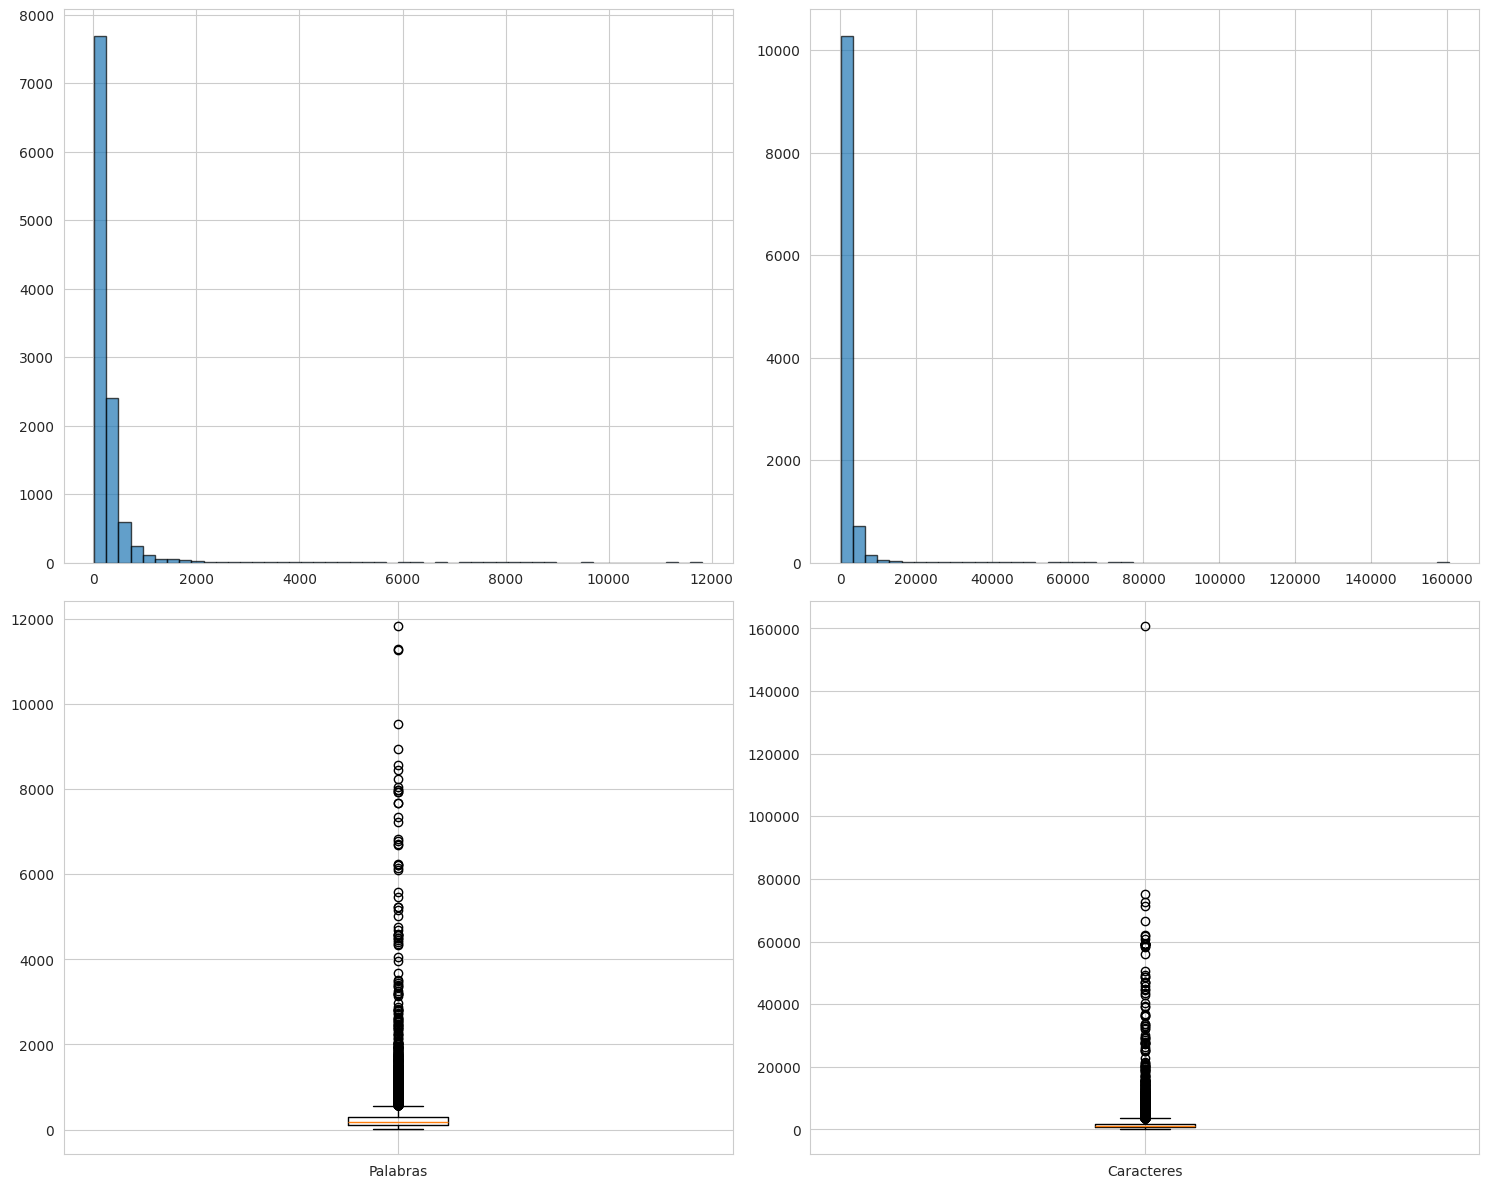


=== ANÁLISIS DE DISTRIBUCIÓN DE ETIQUETAS ===

Total de etiquetas únicas: 20

Distribución de etiquetas:
label_name
rec.sport.hockey            599
soc.religion.christian      598
rec.motorcycles             597
rec.sport.baseball          596
sci.crypt                   595
sci.med                     594
rec.autos                   594
comp.windows.x              593
sci.space                   592
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    589
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 479
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64


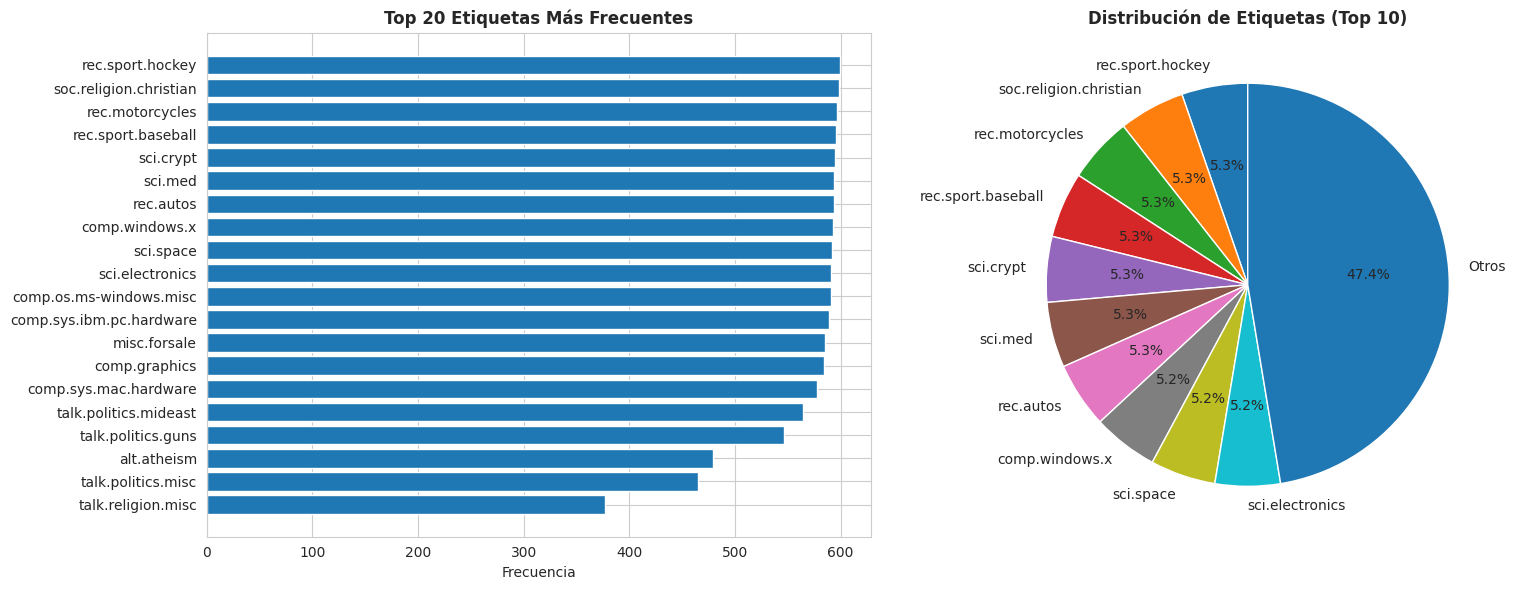


=== ANÁLISIS DE BALANCE DE CLASES ===

Distribución de clases (label numérico):
label
0     479
1     584
2     591
3     589
4     578
5     593
6     585
7     594
8     597
9     596
10    599
11    595
12    591
13    594
14    592
15    598
16    546
17    564
18    465
19    377
Name: count, dtype: int64

Balance de clases:
- Clase 0: 4.24%
- Clase 1: 5.16%
- Clase 2: 5.23%
- Clase 3: 5.21%
- Clase 4: 5.11%
- Clase 5: 5.24%
- Clase 6: 5.17%
- Clase 7: 5.25%
- Clase 8: 5.28%
- Clase 9: 5.27%
- Clase 10: 5.30%
- Clase 11: 5.26%
- Clase 12: 5.23%
- Clase 13: 5.25%
- Clase 14: 5.24%
- Clase 15: 5.29%
- Clase 16: 4.83%
- Clase 17: 4.99%
- Clase 18: 4.11%
- Clase 19: 3.33%

Ratio de balance (min/max): 0.629
⚠ Dataset moderadamente desbalanceado

=== ANÁLISIS DE SPLITS ===

Distribución de splits:
split
train    11307
Name: count, dtype: int64

Porcentajes:
- train: 100.00%

=== ANÁLISIS DE PATRONES - TEXTOS ===
- Emails: 3469 ocurrencias en muestra
- URLs: 0 ocurrencias en muestra
- N

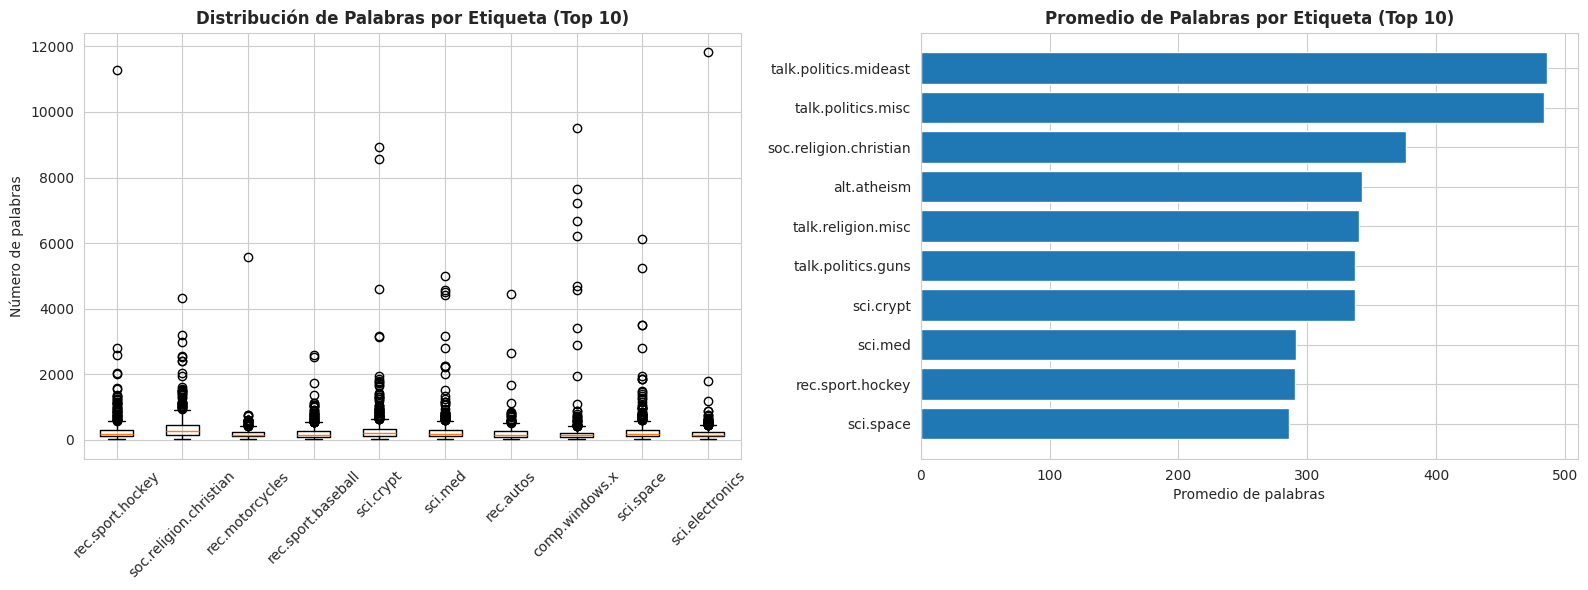


RESUMEN FINAL DEL ANÁLISIS EXPLORATORIO

HALLAZGOS PRINCIPALES:

1. ESTRUCTURA DE DATOS:
   - Total de registros: 11,307
   - Columnas: 5
   - Memoria usada: 23.28 MB

2. CARACTERÍSTICAS DE LONGITUD:
   - Palabras: Promedio 280, Mediana 176
   - Caracteres: Promedio 1885, Mediana 1177
   - Rango: 12 - 11,821 palabras

3. DISTRIBUCIÓN DE ETIQUETAS:
   - Etiquetas únicas: 20
   - Balance: Desbalanceado

4. CALIDAD DE DATOS:
   - Duplicados: 0 (0.00%)
   - Outliers: 912 (8.07%)
   - Textos muy cortos: 0
   - Textos vacíos: 0

5. RECOMENDACIONES:
   - Dataset relativamente balanceado
   - No hay duplicados significativos
   - Textos de longitud adecuada


Análisis completado exitosamente!
Gráficos mostrados en notebook.

=== FIN EDA 20ng ===


In [5]:
run_eda("./news/train.csv", "20ng")

### 3.1.2. Multi-Domain Sentiment EDA

Librerías importadas exitosamente
Cargando dataset...
Dataset cargado: 7200 registros
Columnas: ['text', 'label', 'domain', 'label_id']

=== INFORMACIÓN BÁSICA DEL DATASET ===
- Forma: (7200, 4)
- Columnas: ['text', 'label', 'domain', 'label_id']
- Memoria usada: 15.26 MB

=== INFORMACIÓN DETALLADA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      7200 non-null   object
 1   label     7200 non-null   object
 2   domain    7200 non-null   object
 3   label_id  7200 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 225.1+ KB
None

=== VALORES NULOS ===
text        0
label       0
domain      0
label_id    0
dtype: int64

Total de valores nulos: 0

=== ESTADÍSTICAS DESCRIPTIVAS (COLUMNAS NUMÉRICAS) ===
          label_id
count  7200.000000
mean      0.500000
std       0.500035
min       0.000000
25%       0.000000
50%       0.5000

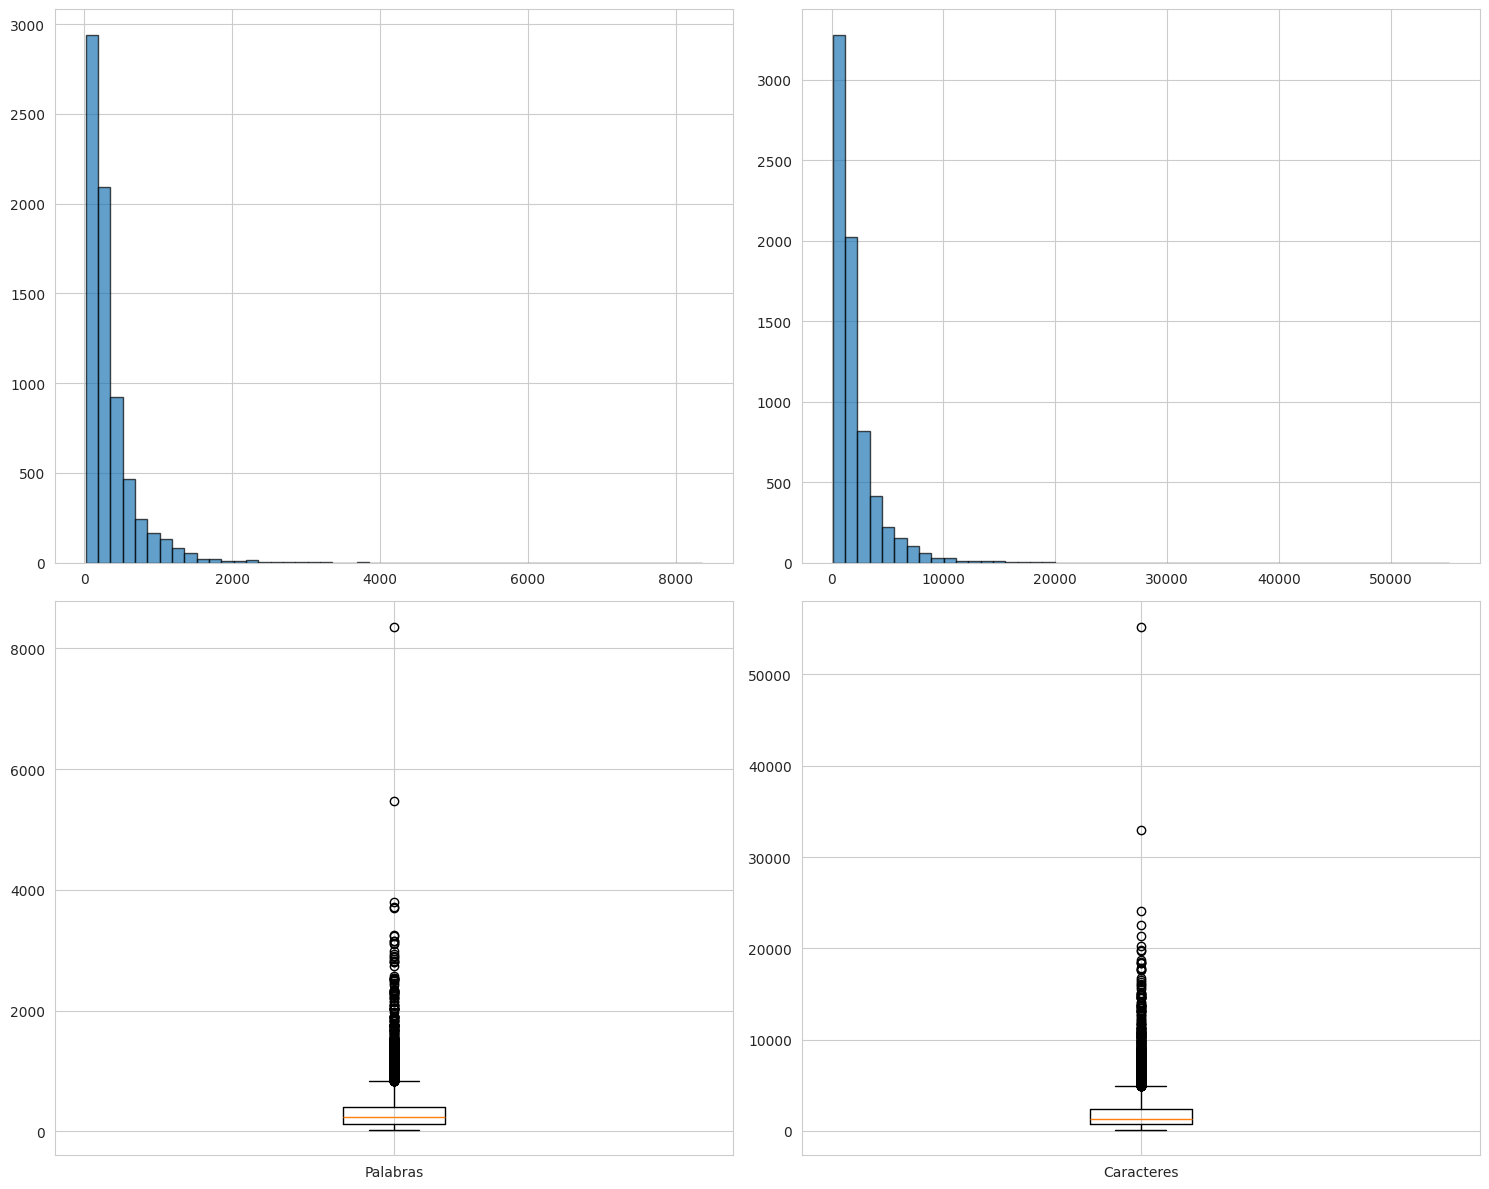


=== ANÁLISIS DE BALANCE DE CLASES ===

Distribución de clases (label numérico):
label
negative    3600
positive    3600
Name: count, dtype: int64

Balance de clases:
- Clase negative: 50.00%
- Clase positive: 50.00%

Ratio de balance (min/max): 1.000
✓ Dataset relativamente balanceado

=== ANÁLISIS DE PATRONES - TEXTOS ===
- Emails: 3 ocurrencias en muestra
  Ejemplos: clark00018@aol.com
- URLs: 0 ocurrencias en muestra
- Números: 1159 ocurrencias en muestra
- Palabras en mayúsculas: 0 ocurrencias en muestra
- Puntuación múltiple: 40 ocurrencias en muestra

Palabras más comunes (top 20):
- the: 11,329
- and: 6,529
- you: 3,572
- this: 2,775
- was: 2,698
- not: 2,628
- that: 2,436
- num: 2,268
- for: 2,086
- one: 1,795
- book: 1,785
- they: 1,746
- with: 1,561
- all: 1,532
- but: 1,435
- like: 1,308
- about: 1,303
- very: 1,275
- are: 1,267
- just: 1,266

=== ANÁLISIS DE CALIDAD DE DATOS ===

1. Duplicados:
- Textos duplicados: 122
- Filas completamente duplicadas: 122
  Porcentaje de 

In [6]:
run_eda("./mdsd/train.csv", "multi")

## 3.2 Prompts

### 5 prompts para 20 Newsgroups

In [4]:
# 5 prompts mejorados para 20 Newsgroups
NEWS_PROMPTS = {
    1: """You are a topic classifier for the 20 Newsgroups dataset.
Text length is typically 100-400 words and may contain email headers, long quotes, or technical jargon.
Do NOT infer sentiment or opinion.
Select exactly ONE topic label based ONLY on topical content:

alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, 
comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, 
rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, 
soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc

Text:
"{texto}"

Answer with the label ONLY, no punctuation, no explanation.
Label:""",


    2: """Classify the following text into one EXACT 20 Newsgroups label.
The dataset includes long emails (median ~176 words; max ~11821). 
Avoid confusing religious content with politics, and avoid mixing rec.sport.* sub-topics.

Allowed labels (20):
alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, 
comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, 
rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, 
soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc

Text:
"{texto}"

Output ONLY the correct label, nothing else:""",


    3: """You are a balanced classifier for 20 Newsgroups.
Dataset is moderately balanced (each class ~4-5 percent). 
Do not bias to sports or religion by default.

Pick ONE topic from the following 20 allowed labels:
alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, 
comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, 
rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, 
soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc

Input text:
"{texto}"

Return ONLY the label:""",


    4: """20 Newsgroups classification task.
Ignore email headers, “From:”, “Subject:”, signatures, and quoted replies.
Classify the MAIN topical content only.

Allowed labels (20):
alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, 
comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, 
rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, 
soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc

Text: "{texto}"

Label only:""",


    5: """Classify this text into exactly one of the 20 Newsgroups categories.
Output must be valid JSON with key "label" only.

Allowed labels:
["alt.atheism","comp.graphics","comp.os.ms-windows.misc","comp.sys.ibm.pc.hardware",
"comp.sys.mac.hardware","comp.windows.x","misc.forsale","rec.autos","rec.motorcycles",
"rec.sport.baseball","rec.sport.hockey","sci.crypt","sci.electronics","sci.med","sci.space",
"soc.religion.christian","talk.politics.guns","talk.politics.mideast","talk.politics.misc",
"talk.religion.misc"]

Text:
"{texto}"

Output:
{"label": ""}"""
}

Etiquetas

In [5]:
NEWS_LABELS = [
    "alt.atheism","comp.graphics","comp.os.ms-windows.misc","comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware","comp.windows.x","misc.forsale","rec.autos","rec.motorcycles",
    "rec.sport.baseball","rec.sport.hockey","sci.crypt","sci.electronics","sci.med","sci.space",
    "soc.religion.christian","talk.politics.guns","talk.politics.mideast","talk.politics.misc",
    "talk.religion.misc"
]

### 5 prompts para Multi-Domain Sentiment 

In [6]:
SENTIMENT_PROMPTS = {
    1: """You are a sentiment classifier for the Multi-Domain Sentiment dataset.
The dataset has short reviews (avg ~80-120 words) from domains like Books / DVD / Electronics / Kitchen.
Your task is to output EXACTLY ONE of these 2 classes:
positive
negative

Review:
"{texto}"

Answer with just the class:""",


    2: """Binary sentiment classification.
Ignore brand names, URLs, and marketing boilerplate.
Focus on overall product satisfaction (NOT emotions about shipping experience).

Classes:
positive
negative

Input:
"{texto}"

Output only one class (no punctuation):""",


    3: """Classify sentiment of this consumer review.
If overall judgment is satisfied → positive.
If disappointment / defect / waste / return → negative.
Do not guess a category if sentiment is unclear — choose the dominant polarity in the text.

Return exactly:
positive
negative

Text:
"{texto}"

Label:""",


    4: """Binary review sentiment classification (Multi-Domain).
Dataset is balanced (≈50/50). Do NOT bias toward positive by default.

Allowed output:
positive
negative

Review text:
"{texto}"

Output only the chosen class:""",


    5: """Sentiment classifier for product reviews (target label ONLY).

Options:
"positive" – satisfied, praise, good purchase.
"negative" – complaints, regret, poor quality.

Review:
"{texto}"

Output JSON with key "label", no explanation:
{"label": ""}"""
}

Etiquetas

In [7]:
SENTIMENT_LABELS = ["positive", "negative"]

In [8]:
# ---- Rutas CSV ----
DATASETS = {
    "news": {
        "paths": {
            "train": "/home/estudiante/tldr-uniandes/encoders-vs-decoders-classification/punto2/mi-solution/news/train.csv",
            "val":   "/home/estudiante/tldr-uniandes/encoders-vs-decoders-classification/punto2/mi-solution/news/val.csv",
            "test":  "/home/estudiante/tldr-uniandes/encoders-vs-decoders-classification/punto2/mi-solution/news/test.csv",
        },
        "prompts": NEWS_PROMPTS,
        "labels": NEWS_LABELS,
        "gold_col": "label_name",
        "text_col": "text",
    },
    "mdsd": {
        "paths": {
            "train": "/home/estudiante/tldr-uniandes/encoders-vs-decoders-classification/punto2/mi-solution/mdsd/train.csv",
            "val":   "/home/estudiante/tldr-uniandes/encoders-vs-decoders-classification/punto2/mi-solution/mdsd/val.csv",
            "test":  "/home/estudiante/tldr-uniandes/encoders-vs-decoders-classification/punto2/mi-solution/mdsd/test.csv",
        },
        "prompts": SENTIMENT_PROMPTS,
        "labels": SENTIMENT_LABELS,
        "gold_col": "label_name",
        "text_col": "text",
    }
}

## Modelos usados
Use al menos dos modelos generativos autoregresivos de código abierto con menos de 7 mil millones de parámetros (**7B**), tales como **GPT-2, GPT-Neo-1.3B, OPT-1.3B, Llama 2 7B** o equivalentes.

In [1]:
!pip install -U transformers accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 36.2 MB/s eta 0:00:00


In [9]:
# ---- Modelos a evaluar (4B en 4-bit caben en ~6–8 GB VRAM) ----
MODELS = [
    "unsloth/Qwen3-4B-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
]

### Porque se escogen esos modelos?

Mejores modelo en leadeboards con los siguientes filtros/requerimientos:

- modelo generativos autoregresivos de código abierto
- instruct
- cuantizado a 4 bits para mejor rendimiento en cuanto a velocidad
- menor o igual a 7b de parametros

Leadeboards:
- https://lmarena.ai/leaderboard/text
- https://openlm.ai/chatbot-arena/
- https://maxim-saplin.github.io/llm_chess/
- https://artificialanalysis.ai/
- https://arcprize.org/

# Resultados

Reporte y compare los resultados en términos de **precisión**, **recall**, **F1 (macro y micro)**, y **accuracy**.

In [9]:
!pip install scikit-learn

In [ ]:
import re, json, torch, pandas as pd
from typing import List, Dict, Optional
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report
)
from IPython.display import display

# ============================
# Utilidades
# ============================
def compute_metrics(df: pd.DataFrame, labels: List[str], title: str = "") -> dict:
    y_true = df["gold"].astype(str).tolist()
    y_pred = df["pred"].astype(str).tolist()

    acc = accuracy_score(y_true, y_pred)
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="micro", zero_division=0
    )
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="macro", zero_division=0
    )
    cls_report = classification_report(
        y_true, y_pred, labels=labels, zero_division=0, output_dict=True
    )

    print("=" * 80)
    print(f"RESULTADOS — {title}")
    print("=" * 80)
    print(f"Accuracy: {acc:.4f}")
    print(f"Micro:   P={p_micro:.4f}  R={r_micro:.4f}  F1={f1_micro:.4f}")
    print(f"Macro:   P={p_macro:.4f}  R={r_macro:.4f}  F1={f1_macro:.4f}")

    per_class_rows = []
    for lab in labels:
        row = cls_report.get(lab, {})
        per_class_rows.append({
            "label": lab,
            "precision": round(row.get("precision", 0.0), 4),
            "recall":    round(row.get("recall",    0.0), 4),
            "f1":        round(row.get("f1-score",  0.0), 4),
            "support":   int(row.get("support",     0)),
        })
    per_class_df = pd.DataFrame(per_class_rows)
    display(per_class_df)
    return {
        "accuracy": acc,
        "precision_micro": p_micro, "recall_micro": r_micro, "f1_micro": f1_micro,
        "precision_macro": p_macro, "recall_macro": r_macro, "f1_macro": f1_macro,
        "classification_report_dict": cls_report,
        "per_class_df": per_class_df,
    }

def extract_label(raw: str, allowed_labels: List[str]) -> Optional[str]:
    """Parsea salida (texto o JSON) y devuelve una etiqueta válida."""
    if raw is None:
        return None
    allowed_set = set(allowed_labels)
    s = raw.strip()

    # JSON {"label": "..."}
    try:
        j = json.loads(s)
        if isinstance(j, dict) and "label" in j:
            cand = str(j["label"]).strip()
            return cand if cand in allowed_set else None
    except Exception:
        pass

    s_clean = re.sub(r'[\s"\'`]+', ' ', s).strip().replace('.', '').strip()
    if s_clean in allowed_set:
        return s_clean

    tokens = re.split(r'[\s,;:]+', s_clean)
    for t in tokens:
        if t in allowed_set:
            return t

    lower_map = {lbl.lower(): lbl for lbl in allowed_labels}
    for t in tokens:
        tt = t.lower()
        if tt in lower_map:
            return lower_map[tt]
    return None

def load_chat_model(model_name: str):
    """Carga tokenizer+modelo (cuida VRAM)."""
    torch.set_grad_enabled(False)
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto" if torch.cuda.is_available() else None,
        dtype=getattr(torch, "bfloat16", None) or getattr(torch, "float16", None)
    )
    model.eval()
    return tok, model

@torch.no_grad()
def generate_label_for_text(tokenizer, model, text: str, prompt_id: int,
                            prompts: Dict[int, str], allowed_labels: List[str],
                            max_new_tokens: int = 16, temperature: float = 0.0, top_p: float = 1.0) -> Optional[str]:
    prompt = prompts[prompt_id].format(texto=text)
    messages = [{"role": "user", "content": prompt}]
    inputs = tokenizer.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt",
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,          # determinista para clasificación
        temperature=temperature,  # ignorado si do_sample=False
        top_p=top_p,
        num_beams=1,
        use_cache=True,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    return extract_label(gen, allowed_labels)

def evaluate_csv(csv_path: str, tokenizer, model,
                 prompts: Dict[int, str], allowed_labels: List[str],
                 gold_col: str = "label_name", text_col: str = "text",
                 prompt_ids: List[int] = [1], limit: Optional[int] = None,
                 show_progress: bool = True) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    if limit:
        df = df.head(limit).copy()

    preds = []
    it = range(len(df))
    if show_progress:
        it = tqdm(it, desc=f"Evaluating {csv_path} prompts {prompt_ids}")

    for i in it:
        txt = str(df.loc[i, text_col])
        if len(prompt_ids) == 1:
            pred = generate_label_for_text(tokenizer, model, txt, prompt_ids[0], prompts, allowed_labels)
        else:
            votes = [generate_label_for_text(tokenizer, model, txt, pid, prompts, allowed_labels)
                     for pid in prompt_ids]
            # Votación simple
            counts = {}
            for v in votes:
                if v in allowed_labels:
                    counts[v] = counts.get(v, 0) + 1
            pred = max(counts, key=counts.get) if counts else ""
        preds.append(pred if pred is not None else "")

    out = pd.DataFrame({
        "text": df[text_col],
        "gold": df[gold_col].astype(str),
        "pred": preds
    })
    out["correct"] = (out["gold"] == out["pred"]).astype(int)
    acc = out["correct"].mean()
    print(f"Accuracy @ {csv_path} → {acc:.4f} (n={len(out)})")
    return out

In [14]:
# ============================
# EVALUAR SOLO EN TEST (5 prompts × modelos × datasets) — SMOKE TEST 3 filas
# ============================
from tqdm.auto import tqdm

# ===== Parámetros de inferencia (rápidos/estables en 15 GB VRAM) =====
GEN_KW = dict(max_new_tokens=16, temperature=0.0, top_p=1.0)

summary_rows = []
detailed_results = {}   # (model, dataset, prompt) -> métricas (solo test)

for model_name in MODELS:
    print("\n" + "#"*90)
    print(f"# CARGANDO MODELO: {model_name}")
    print("#"*90)
    tokenizer, model = load_chat_model(model_name)

    for ds_name, cfg in DATASETS.items():
        print("\n" + "-"*80)
        print(f"DATASET: {ds_name}  (solo TEST — LIMIT=3)")
        print("-"*80)

        prompts   = cfg["prompts"]
        labels    = cfg["labels"]
        test_path = cfg["paths"]["test"]
        gold_col  = cfg["gold_col"]
        text_col  = cfg["text_col"]

        for pid in [1,2,3,4,5]:
            print(f"\n=== TEST — PROMPT {pid} ===")

            @torch.no_grad()
            def _gen(txt):
                return generate_label_for_text(
                    tokenizer, model, txt, pid, prompts, labels, **GEN_KW
                )

            # *** aquí limitamos a 3 ***
            df = pd.read_csv(test_path).head(3)   

            preds = []
            for i in tqdm(range(len(df)), desc=f"{model_name} | {ds_name} | p{pid}"):
                pred = _gen(str(df.loc[i, text_col]))
                preds.append(pred if pred is not None else "")

            res_test = pd.DataFrame({
                "text": df[text_col],
                "gold": df[gold_col].astype(str),
                "pred": preds
            })
            res_test["correct"] = (res_test["gold"] == res_test["pred"]).astype(int)

            print(f"Accuracy preliminar: {res_test['correct'].mean():.4f}")

            m_test = compute_metrics(
               res_test, labels,
               title=f"{ds_name.upper()} TEST — {model_name} — prompt {pid}"
            )

            detailed_results[(model_name, ds_name, pid)] = m_test

            summary_rows.append([
                model_name, ds_name, pid,
                m_test["accuracy"], m_test["f1_macro"], m_test["f1_micro"],
                m_test["precision_macro"], m_test["recall_macro"]
            ])

summary_df = pd.DataFrame(summary_rows, columns=[
    "model","dataset","prompt",
    "accuracy","f1_macro","f1_micro","precision_macro","recall_macro"
])
display(summary_df.sort_values(["dataset","model","f1_macro"], ascending=[True, True, False]))

best_df = (summary_df
           .sort_values(["dataset","model","f1_macro"], ascending=[True, True, False])
           .groupby(["dataset","model"], as_index=False)
           .first())
print("\nMEJOR PROMPT POR MODELO/DATASET (criterio: F1-macro):")
display(best_df)


##########################################################################################
# CARGANDO MODELO: unsloth/Qwen3-4B-unsloth-bnb-4bit
##########################################################################################

--------------------------------------------------------------------------------
DATASET: news  (solo TEST — LIMIT=3)
--------------------------------------------------------------------------------

=== TEST — PROMPT 1 ===


unsloth/Qwen3-4B-unsloth-bnb-4bit | news | p1: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

Accuracy preliminar: 0.0000
RESULTADOS — NEWS TEST — unsloth/Qwen3-4B-unsloth-bnb-4bit — prompt 1
Accuracy: 0.0000
Micro:   P=0.0000  R=0.0000  F1=0.0000
Macro:   P=0.0000  R=0.0000  F1=0.0000


,label,precision,recall,f1,support
0,alt.atheism,0.0,0.0,0.0,0
1,comp.graphics,0.0,0.0,0.0,0
2,comp.os.ms-windows.misc,0.0,0.0,0.0,0
3,comp.sys.ibm.pc.hardware,0.0,0.0,0.0,1
4,comp.sys.mac.hardware,0.0,0.0,0.0,0
5,comp.windows.x,0.0,0.0,0.0,0
6,misc.forsale,0.0,0.0,0.0,0
7,rec.autos,0.0,0.0,0.0,0
8,rec.motorcycles,0.0,0.0,0.0,0
9,rec.sport.baseball,0.0,0.0,0.0,0



=== TEST — PROMPT 2 ===


unsloth/Qwen3-4B-unsloth-bnb-4bit | news | p2: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Accuracy preliminar: 0.0000
RESULTADOS — NEWS TEST — unsloth/Qwen3-4B-unsloth-bnb-4bit — prompt 2
Accuracy: 0.0000
Micro:   P=0.0000  R=0.0000  F1=0.0000
Macro:   P=0.0000  R=0.0000  F1=0.0000


,label,precision,recall,f1,support
0,alt.atheism,0.0,0.0,0.0,0
1,comp.graphics,0.0,0.0,0.0,0
2,comp.os.ms-windows.misc,0.0,0.0,0.0,0
3,comp.sys.ibm.pc.hardware,0.0,0.0,0.0,1
4,comp.sys.mac.hardware,0.0,0.0,0.0,0
5,comp.windows.x,0.0,0.0,0.0,0
6,misc.forsale,0.0,0.0,0.0,0
7,rec.autos,0.0,0.0,0.0,0
8,rec.motorcycles,0.0,0.0,0.0,0
9,rec.sport.baseball,0.0,0.0,0.0,0



=== TEST — PROMPT 3 ===


unsloth/Qwen3-4B-unsloth-bnb-4bit | news | p3: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Accuracy preliminar: 0.0000
RESULTADOS — NEWS TEST — unsloth/Qwen3-4B-unsloth-bnb-4bit — prompt 3
Accuracy: 0.0000
Micro:   P=0.0000  R=0.0000  F1=0.0000
Macro:   P=0.0000  R=0.0000  F1=0.0000


,label,precision,recall,f1,support
0,alt.atheism,0.0,0.0,0.0,0
1,comp.graphics,0.0,0.0,0.0,0
2,comp.os.ms-windows.misc,0.0,0.0,0.0,0
3,comp.sys.ibm.pc.hardware,0.0,0.0,0.0,1
4,comp.sys.mac.hardware,0.0,0.0,0.0,0
5,comp.windows.x,0.0,0.0,0.0,0
6,misc.forsale,0.0,0.0,0.0,0
7,rec.autos,0.0,0.0,0.0,0
8,rec.motorcycles,0.0,0.0,0.0,0
9,rec.sport.baseball,0.0,0.0,0.0,0



=== TEST — PROMPT 4 ===


unsloth/Qwen3-4B-unsloth-bnb-4bit | news | p4: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

Accuracy preliminar: 0.0000
RESULTADOS — NEWS TEST — unsloth/Qwen3-4B-unsloth-bnb-4bit — prompt 4
Accuracy: 0.0000
Micro:   P=0.0000  R=0.0000  F1=0.0000
Macro:   P=0.0000  R=0.0000  F1=0.0000


,label,precision,recall,f1,support
0,alt.atheism,0.0,0.0,0.0,0
1,comp.graphics,0.0,0.0,0.0,0
2,comp.os.ms-windows.misc,0.0,0.0,0.0,0
3,comp.sys.ibm.pc.hardware,0.0,0.0,0.0,1
4,comp.sys.mac.hardware,0.0,0.0,0.0,0
5,comp.windows.x,0.0,0.0,0.0,0
6,misc.forsale,0.0,0.0,0.0,0
7,rec.autos,0.0,0.0,0.0,0
8,rec.motorcycles,0.0,0.0,0.0,0
9,rec.sport.baseball,0.0,0.0,0.0,0



=== TEST — PROMPT 5 ===


unsloth/Qwen3-4B-unsloth-bnb-4bit | news | p5:   0%|          | 0/3 [00:00<?, ?it/s]


KeyError: '"label"'

---

## Análisis y Discusión

* Compare el desempeño entre encoders y decoders para cada dataset y tarea.

* Analice la robustez de cada enfoque frente a la variabilidad de los datos.

* Discuta las ventajas y limitaciones de cada paradigma en términos de:

  * Facilidad de uso y ajuste
  * Requerimientos computacionales
  * Interpretabilidad
  * Adaptabilidad a nuevas tareas o dominios

* Justifique la selección de prompts y analice la sensibilidad de los resultados frente a su formulación.

* Incluya un apartado de recomendaciones sobre el uso de encoders y decoders para tareas de clasificación de texto en función de los resultados obtenidos.

---

## Entrega

* Suba todos los notebooks, el informe PDF y los archivos necesarios a la plataforma indicada.

* No envíe la tarea por correo electrónico.

---

## Notas

* Se valorará el rigor experimental, la claridad en la justificación de las decisiones tomadas y la profundidad del análisis comparativo.

* Puede apoyarse en Transformers de HuggingFace y librerías asociadas.

* Si utiliza recursos computacionales limitados, puede reducir el tamaño del conjunto de datos o el número de épocas, pero debe justificarlo adecuadamente.

---
